# Projet 6 : Classifiez automatiquement des biens de consommation

Dans ce projet, il est demandé d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories.

Le jeu de données peut se télécharger à l'adresse suivante : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip

Les données représentent 1050 images. Chaque image contient une description associée et est catégorisé suivant un système d'arbres. 

Les descriptions et les images numériques vont être traités séparament et les features extraites de chacune des deux méthodes vont être concaténés pour effectuer une unique séparation visuelle.

#### Méthodologie pour les descriptions :
- 1. Vectoriser par tf-idf l'ensemble des descriptions de toutes les images


#### Méthodologie pour les images :
- 1. Récupérer les descripteurs de chaque image par un algorithme de type SIFT
- 2. Clusteriser l'ensemble de tous les descripteurs
- 3. Associer les descripteurs de chaque image aux centres obtenus par clustering
- 4. Faire un bag of words des descripteurs de chaque image, pour toutes les images
   
L'ensemble des features obtenus par ls méthodologie 1 et 2 sont regroupés, normalisés puis les données sont réduites par TSNE pour regrouper visuellement les catégories de produits entre-elles.


#### Chargement des librairies

In [1]:
# Librairies communes ML
import os
import string
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import pickle

# Cross-validation et hyperparamétrisation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold

# OpenCV pour l'algorithme SIFT
import cv2 
from PIL import Image, ImageOps
from PIL import ImageFilter
from glob import glob

# Analyse de texte
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Transformateurs de variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# Librairie de Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# Metriques de Clustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# Metriques de Segmentation
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix

# Réduction de dimensions
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA

# Création de pipelines
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

# Transfert Learning
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from tensorflow.python.keras import Model, layers
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf

from gensim.models import ldamodel
import gensim.corpora


In [2]:
# Chemin d'accès aux données
path = "C:/OpenClassRoom/Projet_6/"
# Lecture des données
df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

## 1. Description des données

#### 1.1 Apperçu des données

In [3]:
# Affichage des 5 premières lignes
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


#### 1.2 Structure des données

In [4]:
# Structure des données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
uniq_id                    1050 non-null object
crawl_timestamp            1050 non-null object
product_url                1050 non-null object
product_name               1050 non-null object
product_category_tree      1050 non-null object
pid                        1050 non-null object
retail_price               1049 non-null float64
discounted_price           1049 non-null float64
image                      1050 non-null object
is_FK_Advantage_product    1050 non-null bool
description                1050 non-null object
product_rating             1050 non-null object
overall_rating             1050 non-null object
brand                      712 non-null object
product_specifications     1049 non-null object
dtypes: bool(1), float64(2), object(12)
memory usage: 116.0+ KB


Chaque ligne correspond à une image, avec son nom et ses caractéristiques associés telle qu'une description, la catégorie du produit etc...

Le nom de l'image permet d'aller la récupérer facilement dans les dossiers pour une lecture simplifié

#### 1.3 Données manquantes

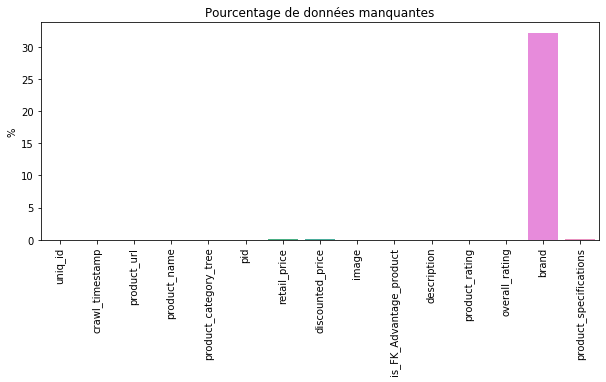

In [5]:
# Calcul du nombre de valeurs manquantes par colonne
df_na = df.isna().sum()/len(df)*100
# Affichage graphique
fig = plt.figure(1, figsize=(10, 4))
sns.barplot(x=df_na.index, y=df_na.values)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("%")
plt.title("Pourcentage de données manquantes")
plt.show()

In [6]:
# Les valeurs manquantes pour la variable "brand" sont remplacés par "".
df["brand"].fillna("", inplace=True)

#### 1.3 Catégories d'images

Chaque image est catégorisé par un système d'arbres avec plusieurs profondeurs. Le nom de la colonne renseignant les catégories est 'product_category_tree'

In [7]:
# Exemple de la catégorie d'un produit
print(df["product_category_tree"][0])

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


In [8]:
# On récupère la colomne "product_category_tree"
list_categories_1, list_categories_2 = [], []
for txt in df["product_category_tree"] :
    
    list_categories_1.append(txt.split(">>")[0].split("\"")[1].strip()) # split du nom par >> et on récupère la première partie
    list_categories_2.append(txt.split(">>")[1].strip()) # split du nom par >> et on récupère la première partie

# Création d'une nouvelle série catégorie    
df["categories_1"] = pd.Series(list_categories_1)
df["categories_2"] = pd.Series(list_categories_2)

print("Il y a {} catégories dans la pronfondeur 1 et {} categories pour la profondeur 2".format(df["categories_1"].nunique(), df["categories_2"].nunique()))


Il y a 7 catégories dans la pronfondeur 1 et 63 categories pour la profondeur 2


##### Affichage des catégories de la première profondeur

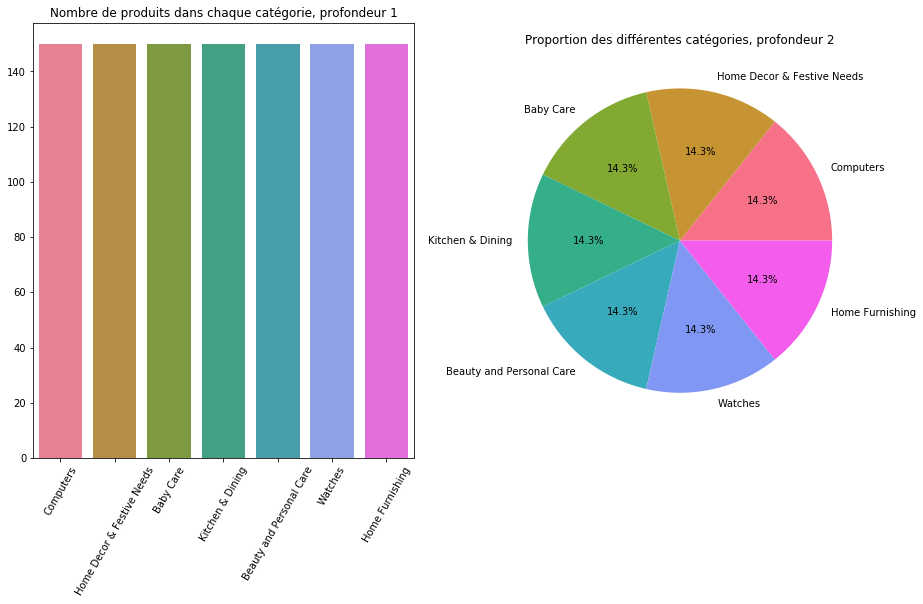

In [9]:
# Histogramme et Pieplot de la répartition des catégories dans la profondeur 1
fig = plt.figure(1, figsize=(15, 8))
categories_1 = df["categories_1"].value_counts()
plt.title("Proportion des différentes catégories")

sns.set_palette(sns.color_palette("husl", len(categories_1)))

# Barplot
plt.subplot(1, 2, 1)
plt.title("Nombre de produits dans chaque catégorie, profondeur 1")

sns.barplot(categories_1.index, categories_1.values, orient="v")
plt.xticks(rotation=60)

# Pieplot
plt.subplot(1, 2, 2)
plt.title("Proportion des différentes catégories, profondeur 2")
            
plt.pie(categories_1, labels=list(categories_1.index), autopct='%1.1f%%')
plt.show()


- Il y a 150 images par catégorie de première profondeur

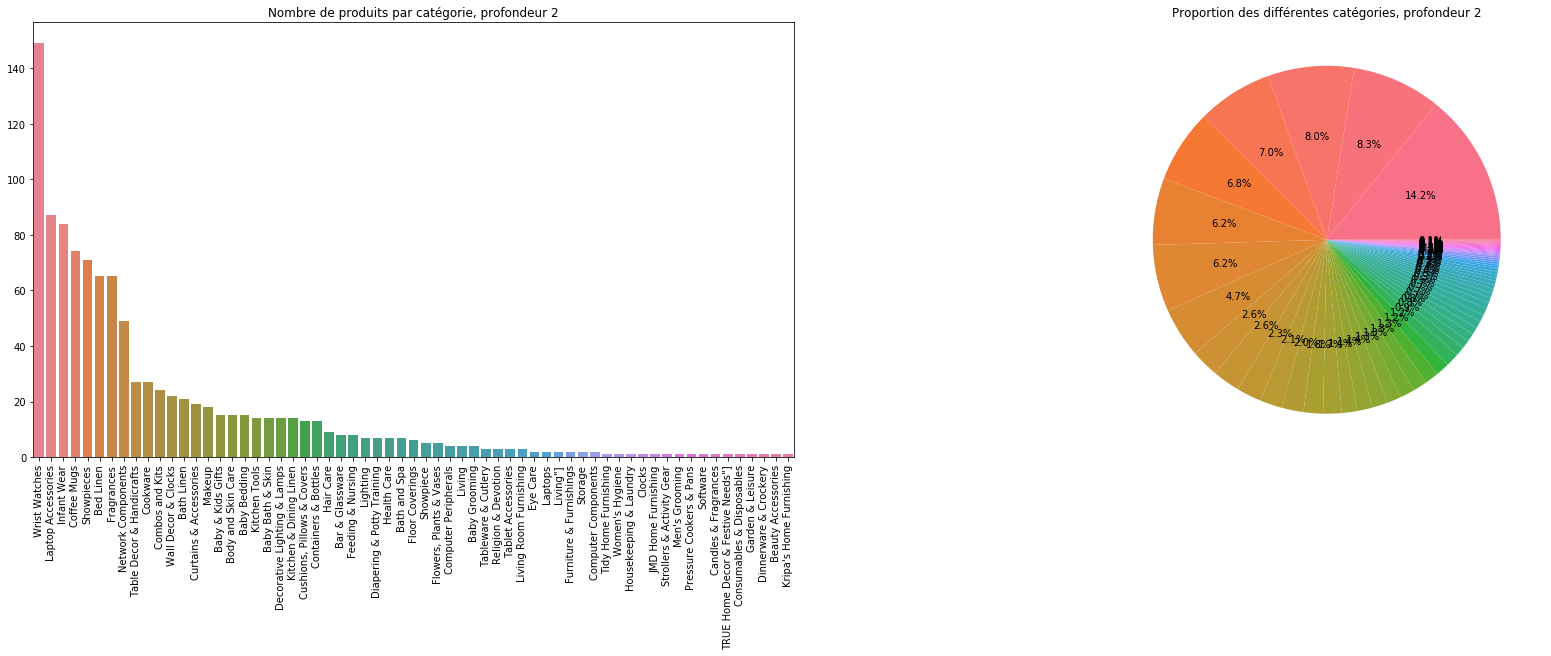

In [10]:
# Histogramme et Pieplot de la répartition des catégories dans la profondeur 2
fig = plt.figure(1, figsize=(30, 8))
categories_2 = df["categories_2"].value_counts()

plt.title("Proportion des différentes catégories")

sns.set_palette(sns.color_palette("husl", len(categories_2)))

# Barplot 
plt.subplot(1, 2, 1)
plt.title("Nombre de produits par catégorie, profondeur 2")

sns.barplot(categories_2.index, categories_2.values, orient="v")
plt.xticks(rotation=90)

# Pieplot
plt.subplot(1, 2, 2)
plt.title("Proportion des différentes catégories, profondeur 2")
plt.pie(categories_2, autopct='%1.1f%%')

plt.show()

Il y a 63 catégories différentes pour la profondeur 2 et la répartition des images dans les catégories est très inégale, avec des catégories qui possèdent 149 images contre 1 pour certaines

La profondeur 1 est donc choisi

In [11]:
# Les catégories utilisés pour la résolution du problème de segmentation
categories = df["categories_1"]

#### 1.4 Exemples d'images

Voici un exemple de chaque catégorie

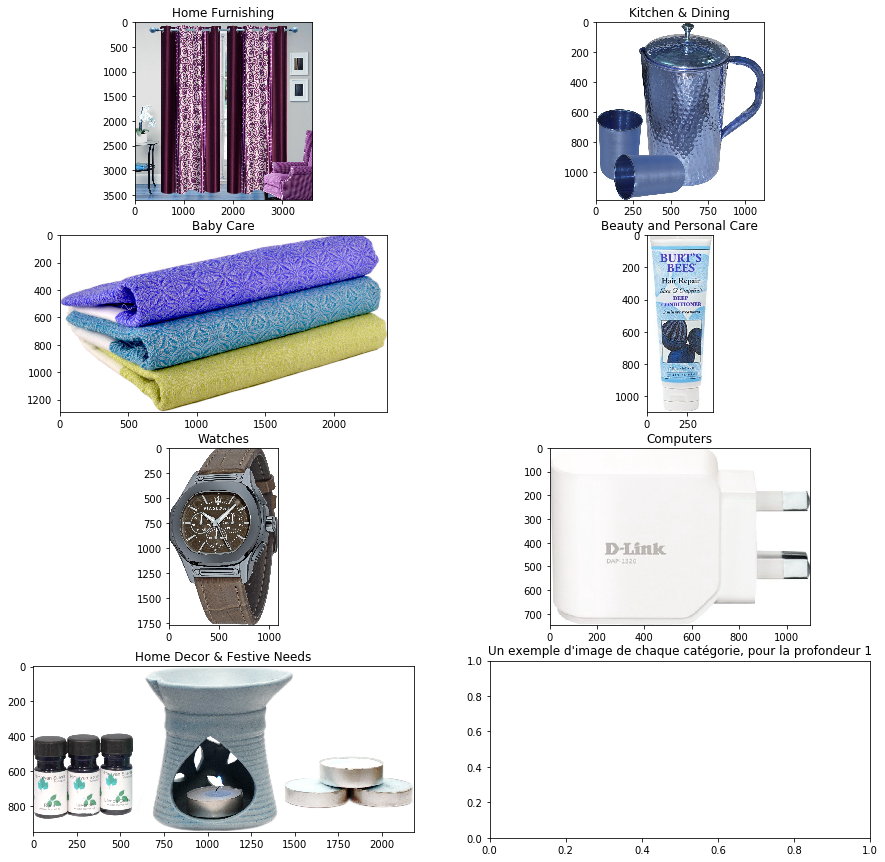

In [12]:
fig, ax = plt.subplots(4, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.title("Un exemple d'image de chaque catégorie, pour la profondeur 1")
for i, categ in enumerate(df["categories_1"].unique()) :
    name_image = df[df["categories_1"] == categ]["image"].iloc[0]
    img = cv2.imread(path + "Images/" + name_image)
    ax[i%4, i//4].set_title(categ)
    ax[i%4, i//4].imshow(img)

    
plt.show()

Voici un exemple de chaque catégorie d'image pour la profondeur 2

#### 1.5 Descriptif des articles 

Ci-dessous, vous trouverez un exemple de texte descriptif du produit

In [12]:
print("La catégorie du produit est {} \n".format(categories.iloc[0]))

print("Le descriptif du produit est : \n \n {}".format(df["description"].iloc[0]))

La catégorie du produit est Home Furnishing 

Le descriptif du produit est : 
 
 Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. B

## 2. Nettoyage des données et pré-traitement des images

#### 2.1 Doublons dans le jeu de données

In [70]:
print("Existe t-il des doublons dans le jeu de données ? {}".format(len(df)!=df["uniq_id"].nunique()))

Existe t-il des doublons dans le jeu de données ? False


#### 2.2 Concaténation des variables textes : "product_name", "description" et "brand"

In [71]:
df["description"] = df["product_name"] + df["brand"] + df["description"]

Toutes les informations textes à notre disposition sont rassemblés dans une unique chaine de caractères. Sont donc regroupés le nom du produit, la marque ainsi que la description du produit

#### 2.3 Pré-traitement des images

In [18]:
# Vrai ou Faux si les images doivent être pré-traités
preprocess_image = True
Images = []
if preprocess_image :

    for name_img in df["image"] :

        img = Image.open(os.path.join(path + "Images/", name_img)) # Lecture de l'image
        img = ImageOps.autocontrast(img) # Auto contrast
        img = ImageOps.equalize(img) # Egalisation de l'histogramme
        img = img.filter(ImageFilter.BoxBlur(1)) # Lissage pour eliminer le bruit
        img = cv2.resize(np.array(img), (224, 224)) # Resize en 224*224
        Images.append(img)
        img = Image.fromarray(img) # Transforme un array en Image
        img.save(os.path.join(path + "Images_transformed/", name_img)) # Sauvegarde de l'image

## 3. Segmentation

Dans cette partie, il s'agit de segmenter nos données textuelles et visuelles afin d'étudier la faisabilité d'une classification. Il s'agit donc de déterminer si une segmentation (insupervisé) peut permettre de regrouper nos données en catégories, analogues à celles de la profondeur 1 de notre arbre.

Il existe diverses méthodes d'encodage de données textuelles, comme le bag-of-words et le tf-idf.

#### Bag-of-words : 

Le bag-of-words consiste à créer une colonne pour chaque mot différent présent pour l'ensemble des textes et d'indiquer le nombre de fois qu'il apparait dans chaque texte. L'histogramme associé consiste à indiquer la fréquence normalisé de l'apparition de chacun des mots dans chaque texte pour l'ensemble du corpus de textes.
#### TF-IDF :

<img src="tf_idf.png">

Cette mesure statistique permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus. Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document. Il varie également en fonction de la fréquence du mot dans le corpus.

#### LDA ( Latent Dirichlet Allocation) :

L’allocation de Dirichlet latente (de l'anglais Latent Dirichlet Allocation) ou LDA est un modèle génératif probabiliste permettant d'expliquer des ensembles d'observations, par le moyen de groupes non observés, eux-mêmes définis par des similarités de données.

Par exemple, si les observations (β) sont les mots collectés dans un ensemble de documents textuels (M), le modèle LDA suppose que chaque document (M) est un mélange (θ) d'un petit nombre de sujets ou thèmes (α topics), et que la génération de chaque occurrence d'un mot (w) est attribuable (probabilité) à l'un des thèmes (t) du document
    

<img src="lda.png">

##### Méthode de visulisation graphique, TSNE :

L'algorithme de t-SNE (t-distributed stochastic neighbor embedding) est une technique de réduction de dimension pour la visualisation de données.

Il s'agit d'une méthode non-linéaire permettant de représenter un ensemble de points d'un espace à grande dimension dans un espace à deux ou trois dimensions.

L'algorithme t-SNE tente de trouver  une configuration optimale selon un critère de théorie de l'information pour respecter les proximités entre points : deux points qui sont proches (resp. éloignés) dans l'espace d'origine devront être proches (resp. éloignés) dans l'espace de faible dimension.

L'algorithme t-SNE se base sur une interprétation probabiliste des proximités. Une distribution de probabilité est définie sur les paires de points de l'espace d'origine de telle sorte que des points proches l'un de l'autre ont une forte probabilité d'être choisis tandis que des points éloignés ont une faible probabilité d'être sélectionnés. Une distribution de probabilité est également définie de la même manière pour l'espace de visualisation. L'algorithme t-SNE consiste à faire concorder les deux densités de probabilité, en minimisant la divergence de Kullback-Leibler entre les deux distributions par rapport à l'emplacement des points sur la carte.

### 3.1 Traitement du descriptif des articles

In [15]:
# Défini les indices d'entrainement et de validation
# pour l'hyperparamétrisation de la cross-validation
skf = KFold(n_splits=10, shuffle=True, random_state=42)

In [16]:
# Dictionnaire des résultats, key: nom méthode, value : ARI Score
scores = {}

# Dictionnaire de grid_search pour la conservation des modèles
results_txt = {}
results_img = {}
grid_search_dict = {}
ARI = {}

In [17]:
def define_pipeline(preprocessor, predictor) :
    """
    Assemblage des pipelines pré-traitement des données + clustering
        :preprocessor(transformator) : Transforme les données pour le prédicteur
        :predictor(predictor) : Effectue une prédiction
    
    """

    pipeline = Pipeline([("preprocess", preprocessor),
                         ("predictor", predictor),
                       ])
    return pipeline

#### Exemple en sortie de la fonction Tf-idf

In [72]:
vect = TfidfVectorizer(
                    strip_accents='unicode',
                    lowercase=True,
                    stop_words='english',
                    analyzer='word',
                    max_df=0.5,
                    min_df=5,
                    ngram_range=(1, 2))

out = vect.fit_transform(df["description"].values.astype('U'), categories)
# Mise sous forme de DataFrame
ex_tfidf = pd.DataFrame(out.toarray(), columns=vect.get_feature_names())
# Affichage des 5 premières lignes
ex_tfidf.head()

,01,10,10 cm,100,100 cotton,100 percent,100 pure,1000,11,1100,...,years come,yellow,yellow price,yes,yes box,yes dimensions,yes material,yes microwave,yes type,yes warranty
0,0.0,0.000000,0.0,0.036133,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.132535,0.0,0.051935,0.0,0.0,0.085458,0.0,0.000000,0.0
2,0.0,0.041921,0.0,0.075973,0.044884,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.030467,0.0,0.0,0.000000,0.0,0.045637,0.0
4,0.0,0.000000,0.0,0.060614,0.071621,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.028286,0.0,0.0,0.000000,0.0,0.000000,0.0


Les colonnes représentent les différents termes retenus par la méthode. Chaque ligne correspond à un descriptif produit. Les valeurs correspondent au calcul du Tf-idf précédement définis

#### 3.1.1 Méthode Tf-idf + k-means

In [73]:
# Grille d'hyperparamètres pour le Tf-idf
hyperparameters = {
                   "preprocess__max_df": [0.1, 0.2, 0.5, 0.8], # ignore terms that appear in more than max_df*100% of the documents
                   "preprocess__min_df": [1, 3, 5], # only keep terms that appear in at least min_df documents
                   "preprocess__ngram_range": [(1, 1), (1, 2)]    
                  }

In [74]:
# Tf-idf avec stops words et n_gram
vect = TfidfVectorizer(
                    strip_accents='unicode',
                    lowercase=True,
                    stop_words='english',
                    analyzer='word')

# Pipeline Tf-idf + k-means
pipeline = define_pipeline(vect, KMeans(n_clusters=categories.nunique()))

grid_search = RandomizedSearchCV(pipeline,
                                 param_distributions=hyperparameters,
                                 scoring='adjusted_rand_score',
                                 cv=skf)

grid_search.fit(df["description"].values.astype('U'), categories)

print("Adjusted Rand Score : {}".format(grid_search.best_score_))
print("Les meilleurs paramètres sont : {}".format(grid_search.best_params_))
# Le meilleur score est enregistré dans le dictionnaire des scores
ARI["Text_Tf-idf"] = grid_search.best_score_
# Conservation du grid search
grid_search_dict["Text_Tf-idf"] = grid_search.best_estimator_
results_txt["Text_Tf-idf"] = grid_search.best_estimator_[0].transform(df["description"].values.astype('U'))

Adjusted Rand Score : 0.32239964785525616
Les meilleurs paramètres sont : {'preprocess__ngram_range': (1, 2), 'preprocess__min_df': 3, 'preprocess__max_df': 0.5}


#### 3.1.2 Méthode BoW + LDA

In [75]:
class TemplateClassifier(BaseEstimator, ClassifierMixin):
            
        
    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):

        # Check is fit had been called
        #check_is_fitted(self)

        # Input validation
        X = check_array(X)

        closest = np.argmax(X, axis=1)
        return self.y_[closest]

In [76]:
# Grille d'hyperparamètres pour le pipeline
# Latent Dirichlet Allocation + KMeans
hyperparameters_bow_lda = {
                   "preprocess__BOW__max_df": [0.1, 0.2, 0.5, 0.8], # ignore terms that appear in more than max_df*100% of the documents
                   "preprocess__BOW__min_df": [1, 3, 5], # only keep terms that appear in at least min_df documents
                   "preprocess__BOW__ngram_range": [(1, 1), (1, 2)]    
                  }

In [77]:
# Pipeline Bag of Words + LDA
bow_lda_pipeline = Pipeline(steps=[
        ('BOW', CountVectorizer(                    
                    strip_accents='unicode',
                    lowercase=True,
                    stop_words='english',
                    analyzer='word')), # Bag_of_words
        ('lda', LatentDirichletAllocation(n_components=categories.nunique())),

    ])

In [78]:
pipeline = define_pipeline(bow_lda_pipeline, KMeans(n_clusters=categories.nunique()))
#pipeline = define_pipeline(bow_lda_pipeline, TemplateClassifier())


grid_search = RandomizedSearchCV(pipeline,
                            hyperparameters_bow_lda, # Grille d'hyperparamètres
                            scoring='adjusted_rand_score', # Métrique d'évaluation
                            cv=skf # Découpage du jeu de données en entrainement/validation
                            )

grid_search.fit(df["description"].values.astype('U'), categories)

print("Adjusted Rand Score : {}".format(grid_search.best_score_))
print("Les meilleurs paramètres sont : {}".format(grid_search.best_params_))

ARI["Text_BOW_LDA"] = grid_search.best_score_

# Conservation du grid search
grid_search_dict["Text_BOW_LDA"] = grid_search.best_estimator_ # Selection du meilleur estimateur
results_txt["Text_BOW_LDA"] = grid_search.best_estimator_[0].transform(df["description"].values.astype('U'))

Adjusted Rand Score : 0.2802496833213405
Les meilleurs paramètres sont : {'preprocess__BOW__ngram_range': (1, 1), 'preprocess__BOW__min_df': 3, 'preprocess__BOW__max_df': 0.5}


#### 3.1.3 Méthode Tf-idf + NMF

In [79]:
class Normalize(BaseEstimator, TransformerMixin) :
    
    """
    Classe Normalize qui permet de normaliser les données, en utilisant
    la syntaxe des pipelines de sklearn
    """
           
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return normalize(X, norm='l1', axis=1)

In [80]:
# Grille d'hyperparamètres pour Tf-idf + NMF + KMeans
hyperparameters_nmf = {
                   "preprocess__Tf-idf__max_df": [0.1, 0.2, 0.5, 0.8, 0.9], # ignore terms that appear in more than max_df*100% of the documents
                   "preprocess__Tf-idf__min_df": [1, 3, 5, 8, 10], # only keep terms that appear in at least min_df documents
                   "preprocess__Tf-idf__ngram_range": [(1, 2), (1, 3), (1, 4)]    
                  }

In [81]:
# Pipeline Tf-idf + normalize + NMF
nmf_pipeline = Pipeline(steps=[
    ('Tf-idf', TfidfVectorizer(   
                    strip_accents='unicode',
                    lowercase=True,
                    stop_words='english',
                    analyzer='word')), # Tf-idf
    ('normalize', Normalize()),
    ('nmf', NMF(n_components=categories.nunique())),
    ('std_scaler', StandardScaler()),
    ])

In [82]:
pipeline = define_pipeline(nmf_pipeline, KMeans(n_clusters=categories.nunique()))
#pipeline = define_pipeline(nmf_pipeline, TemplateClassifier())


grid_search = RandomizedSearchCV(pipeline,
                           hyperparameters_nmf, # Grille d'hyperparamètres
                           scoring='adjusted_rand_score', # 
                           cv=skf,  #Découpage du jeu de données en entrainement/validation
                           )

grid_search.fit(df["description"].values.astype('U'), categories)

print("Adjusted Rand Score : {}".format(grid_search.best_score_))
print("Les meilleurs paramètres sont : {}".format(grid_search.best_params_))

ARI["Text_Tf-idf_NMF"] = grid_search.best_score_ # Meilleur score d'une combinaison d'hyperparamètres

# Conservation du grid search
grid_search_dict["Text_Tf-idf_NMF"] = grid_search.best_estimator_ # Selection du meilleur estimateur
results_txt["Text_Tf-idf_NMF"] = grid_search.best_estimator_[0].transform(df["description"].values.astype('U'))

Adjusted Rand Score : 0.28198924603312864
Les meilleurs paramètres sont : {'preprocess__Tf-idf__ngram_range': (1, 4), 'preprocess__Tf-idf__min_df': 8, 'preprocess__Tf-idf__max_df': 0.8}


### 3.2 Traitement des images

#### 3.2.1 Utilisation de SIFT sur chacune des 1050 images

##### Fonction pour l'algorithme SIFT

In [83]:
def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):

    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

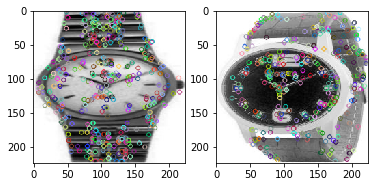

In [84]:
# Exemple 1 d'une image
image_1 = cv2.imread(os.path.join(path + '/Images_Transformed', '71ff6abd7764f2a42fcbefc11429be2d.jpg'))
# Exemple 2 d'une image
image_2 =  cv2.imread(os.path.join(path + '/Images_Transformed', 'dd0e3470a7e6ed76fd69c2da27721041.jpg'))
gray_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
gray_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

#create sift object
sift  = cv2.xfeatures2d.SIFT_create()
#calculate keypoints and their orientation
keypoints_1, descriptors_1 = sift.detectAndCompute(gray_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(gray_2, None)

#plot keypoints on the image
with_keypoints_1 = cv2.drawKeypoints(gray_1, keypoints_1, outImage=gray_1)
with_keypoints_2 = cv2.drawKeypoints(gray_2, keypoints_2, outImage=gray_2)

#plot the image
fig, ax = plt.subplots(1, 2)

# Affichage des descripteurs Sift dans les deux images
ax[0].imshow(with_keypoints_1)
ax[1].imshow(with_keypoints_2)

plt.show()

##### Fonction de normalisation des vecteurs

In [85]:
def sift_features_centers(df, categories, n_centers=200, dir_image=path + "Images_transformed") :
    
    """
    Pour chaque image, applique l'algorithme SIFT pour détecter les descripteurs.
    Ensuite, un k-means est appliqué sur l'ensemble de tous les descripteurs
    puis pour chaque image prise individuellement, k-means prédit pour chaque descripteur le centre associé
    Retourne une liste de liste, lenght=nombre d'images et pour chaque image correspond une liste dont
    la taille est égale au nombre de descripteurs détectés par l'algorithme SIFT
    df(pd.DataFrame): contient 'image' qui correspond au nom de l'image, 'categories' qui est l'étiquette
    de chaque produit
    n_centers(int): correspond au nombre de centres de descripteurs
    dir_image(str): chemin d'accès aux images (pour leur lecture)
    
    """
    
    images = []
    labels = []
    descripteurs = []
    index_to_del = []
    images_desc = []

    for index, image_name in df["image"].iteritems() : # Pour chaque image du jeu de données

        image = cv2.imread(os.path.join(dir_image, image_name)) # Lecture de l'image
        kp, desc = gen_sift_features(image) # Keypoints et descripteurs de l'image

        if (desc is not None) : # Si desc est différent de None
            images.append(np.array(image)) 
            for d in desc : # Pour chaque descripteur de l'image
                # Ajoute chaque descripteur de l'image dans une grande matrice de descripteurs
                descripteurs.append(normalize(d.reshape(1, -1)).ravel()) 
            labels.append(categories.loc[index])
            images_desc.append(normalize(desc))
        else :
            print("Descriptors of Image n° {} is None".format(index))
            index_to_del.append(index)


    descripteurs = np.array(descripteurs)
    labels = np.array(labels)

    km = KMeans(n_clusters=n_centers)

    km.fit(descripteurs)
    centers = []

    for desc in images_desc :
        centers.append(km.predict(desc))
    
    return centers


In [86]:
class Build_histogram(BaseEstimator, TransformerMixin) :
    
    def __init__(self, n_centers=200):
        self.n_centers = n_centers
           
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):     
        result = np.array([[list(X[i]).count(k) for k in range(0, self.n_centers)] for i in range(len(X))])
        return result

#### 3.2.2 Clustering des descripteurs 

In [87]:
# Pipeline Histogramme + Normalize
sift_pipeline = Pipeline(steps=[
        ('BOW', Build_histogram(n_centers=200)), # Bag_of_visual_words
        ('normalize', Normalize()) # Normalisation de l'histogramme
    ])

# KMeans est rajouté au pipeline pour la segmentation
pipeline = define_pipeline(sift_pipeline, KMeans(n_clusters=categories.nunique()))

In [88]:
# Grille d'hyperparamètres pour le clustering des descripteurs
hyperparameters_sift = {
                    'preprocess__k-means__n_clusters': [100, 200, 400],
}

In [89]:
y_pred = cross_val_predict(pipeline,
                           sift_features_centers(df, categories),
                           categories,
                           cv=skf) # Découpage du jeu de données entrainement/validation

score = adjusted_rand_score(categories, y_pred)

print("Adjusted Rand Score : {}".format(score))
ARI["img_Sift_BoVW"] = score 


# Conservation du meilleur modèle et des meilleurs résultats
grid_search_dict["img_Sift_BoVW"] = pipeline
results_img["img_Sift_BoVW"] = pipeline[0].transform(df["description"].values.astype('U'))

Adjusted Rand Score : 0.007121762100606605


#### 3.2.2 Transfert Learning

<img src="resnet.png">

L'architecture complexe du Resnet50 est détaillé ci-dessus. Dans cette partie, nous utilisons ce réseau pré-entrainé en extrayant le résultat de la dernière couche appliqué à nos données. A cette dernière couche est appliqué un algorithme de réduction de dimensions. La méthode k-means permet ensuite de définir des clusters correspondant aux catégories d'images présentes dans notre jeu de données.

In [60]:
# Initilisation du réseau de neurones
model = Sequential()

# Ajout des poids à partir de resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
model.add(ResNet50(include_top=False,
                   pooling='avg',
                   weights='imagenet',
                   input_shape=(224, 224, 3)))

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 7s 0us/step


In [61]:
# Résumé du réseau de neurones: détail de chaque couche
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [62]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemin d'accès aux images
image_dir = 'C:\OpenClassRoom\Projet_6\Images_transformed'


# Jeu d'entrainement
X = np.array([np.array((os.path.join(image_dir, name_image))) for name_image in df["image"]])
# Création de répertoires d'images avec les noms des différentes catégories
for x, y, name_image in zip(X, categories, df["image"]) :
    new_dir = path + "Images_transformed/" + y # Nouveau dossier de sauvegarde
    if not os.path.exists(new_dir):
         os.makedirs(new_dir) # Check si le dossier existe ou non
    img = Image.open(x) # Lecture de l'image
    img.save(os.path.join(new_dir, name_image)) # Sauvegarde dans le dossier de la catégorie associée
    

image_size = 224
BATCH_SIZE_TRAINING = 1050
# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        image_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

Found 1050 images belonging to 7 classes.


In [63]:
# Prédiction par réseau neuronal
output_cnn = model.predict_generator(train_generator)
# Sauvegarde de la sortie du réseau
pickle.dump(output_cnn, open("output_cnn_restnet50.h5", "wb"))

In [67]:
# Méthodologies de réduction de dimmension
reduce_dim = {  
                "PCA": Pipeline(steps=[
                        ('pca', PCA()),
                        ('std_scaler', StandardScaler())
                        ]),
                "NMF": Pipeline(steps=[
                        ('normalize', Normalize()),
                        ('nmf', NMF()),
                        ('std_scaler', StandardScaler()),
                        ])
}


hyperparameters_pca = {
                    "preprocess__pca__n_components": [0.7, 0.8, 0.9, 0.95]  # Ratio de variance à conserver
}


hyperparameters_nmf = {
                    "preprocess__nmf__n_components": [5, 10, 20, 50, 100]  # nombre de dimensions à conserver
}



hyperparameters = {
                    "PCA": hyperparameters_pca,
                    "NMF": hyperparameters_nmf
}


In [68]:
def make_positive(matrix):
    
    def make_positive_col(col):
        col_min = np.min(col)
        if col_min < 0 :
            positive_col = col - col_min
            return positive_col
        elif col_min >=0:
            return col
    
    if (matrix>=0.0).all():
        return matrix
    else :
        positive_mat = np.apply_along_axis(make_positive_col,
                                           axis=1,
                                           arr=matrix)
        return positive_mat

In [69]:
for name_prepro, preprocessor in reduce_dim.items() :
    # Combinaison de l'algo de réduction avec k-means
    pipeline = define_pipeline(preprocessor, KMeans(n_clusters=categories.nunique()))
    
    grid_search = GridSearchCV(pipeline, # Réduction de dimensions + k-means
                               param_grid=hyperparameters[name_prepro], # Grille de paramètres
                               scoring='adjusted_rand_score', # ARI métrique
                               cv=skf) # 10 passes
    
    if name_prepro == "NMF" :
        # Rend la matrice non négative pour l'application de NMF
        X = make_positive(output_cnn)
    else :
        X = output_cnn
        
        
    grid_search.fit(X, categories)
    
    print("Le score ARI avec la méthode de réduction de dimmension {} est de : {}".format(name_prepro,
                                                                                          grid_search.best_score_))
    print(grid_search.best_params_)
    ARI["img_CNN_" + name_prepro] = grid_search.best_score_
    # Conservation du grid search
    grid_search_dict["img_CNN_" + name_prepro] = grid_search.best_estimator_[0]
    results_img["img_CNN_" + name_prepro] = grid_search.best_estimator_[0].transform(X)

Le score ARI avec la méthode de réduction de dimmension PCA est de : 0.003621733875095907
{'preprocess__pca__n_components': 0.95}
Le score ARI avec la méthode de réduction de dimmension NMF est de : 0.01117664595491015
{'preprocess__nmf__n_components': 20}


### 3.3 Concaténation des données textes et images

Les données sont concaténés puis normalisés

In [99]:
results_txt["Text_Tf-idf"] = results_txt["Text_Tf-idf"].toarray()

In [111]:
for name_method_img, data_img in results_img.items() : 
    for name_method_text, data_text in results_txt.items() :
        
        name_method = name_method_text + " & " + name_method_img
        # Concaténation des données textes et images
        X_concat = np.concatenate((data_text, data_img), axis=1)
        # Normalisation des données
        X_std = StandardScaler().fit_transform(X_concat) 
        
        cat_pred = cross_val_predict(KMeans(n_clusters=categories.nunique()),
                                     X_std, # Données
                                     categories,  # Etiquettes
                                     cv=skf,  # Partitionnement des données
                                     n_jobs=-1)
        
        
        ARI[name_method] = adjusted_rand_score(categories, cat_pred)

### 3.4 Résultats et visualisation graphique

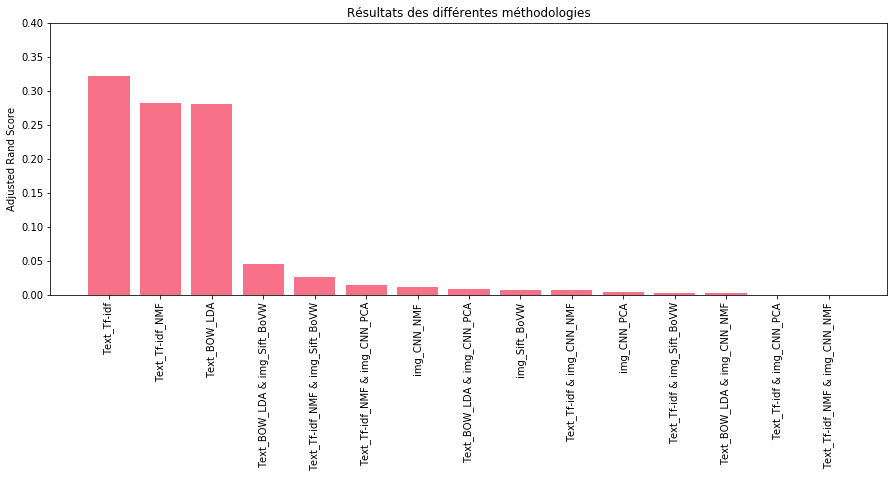

In [112]:
ARI_values = []
ARI_keys = []
# Le dictionnaire de résultat est trié par ordre décroissant des valeurs
for k, v in sorted(ARI.items(), key=lambda x: x[1], reverse=True):
    ARI_values.append(v)
    ARI_keys.append(k)


fig = plt.figure(1, figsize=(15, 5))
plt.bar(range(len(ARI_values)), ARI_values, align='center')
plt.ylim([0, 0.4])
plt.ylabel('Adjusted Rand Score')
plt.title("Résultats des différentes méthodologies")
plt.xticks(range(len(ARI_keys)), ARI_keys, rotation='vertical')

plt.show()

#### Matrice de Confusion

Les labels sont encodés numériquement

In [114]:
# Les catégories d'images sont encodés numériquement de 0 à 6
cat_encoder = LabelEncoder()
y = cat_encoder.fit_transform(categories)

In [113]:
# Labels prédits par le meilleur algorithme
labels_pred = grid_search_dict["Text_Tf-idf"].predict(df["description"].values.astype('U'))

Calcul de la matrice de confusion

In [115]:
# Calcul de la Matrice de confusion
mat_conf = confusion_matrix(y, labels_pred)
# Mise sous forme de DataFrame
mat_conf_df = pd.DataFrame(mat_conf, index=cat_encoder.classes_, columns=range(len(categories.unique())))

Affichage graphique de la matrice de confusion

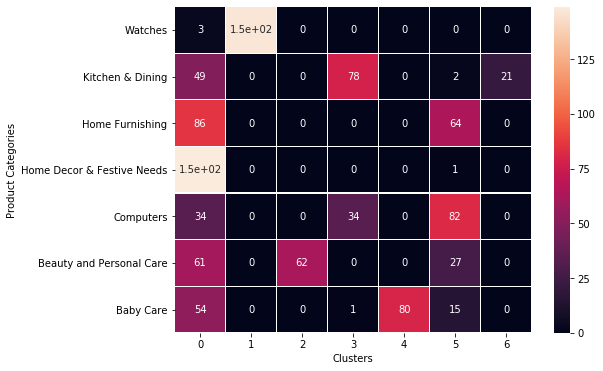

In [116]:
fig = plt.figure(1, figsize=(8, 6))
sns.heatmap(mat_conf_df, annot=True, linewidths=.3)
plt.ylabel('Product Categories')
plt.xlabel('Clusters')
plt.ylim(0, 7)
plt.show()

Les produits de type "Watches", "Baby Care" et "Home Furnishing" sont ceux qui ont été les mieux segmentés puisqu'ils sont regroupés pour l'essentiel dans un cluster. A l'inverse, la catégorie "Kitchen & Dining" est fragmenté, de manière homogène, dans plein de clusters différents.

#### Résultats graphique via TSNE

In [117]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(50, 40)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for i, digit in enumerate(digits):
        sns.scatterplot(X_normalized[y == digit, 0],
                        X_normalized[y == digit, 1],
                        c=[cmap(i / 7)],
                        label=digit)
    plt.xlabel("Composante 1")
    plt.ylabel("Composante 2")
    plt.title("Projection 2D par TSNE")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            
    plt.legend()

In [120]:
tsne = TSNE(perplexity=15)
X_tsne = tsne.fit_transform(results_txt["Text_Tf-idf"])

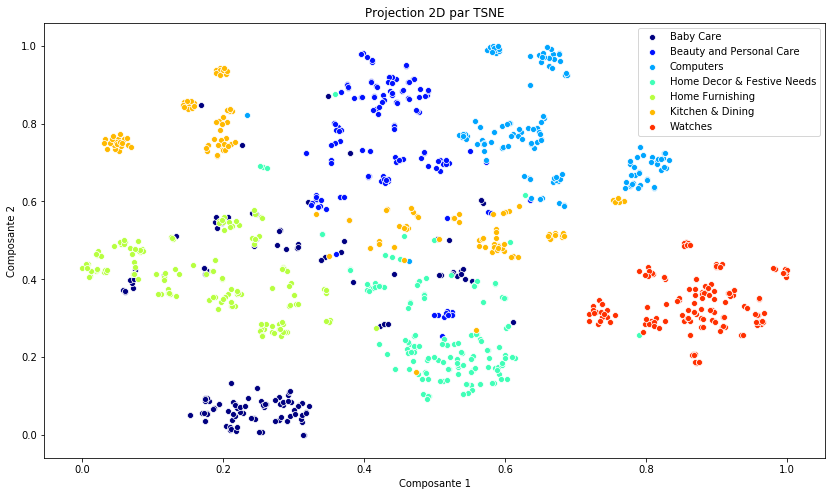

In [121]:
# Affichage graphique des résultats de la TSNE
plot_digits(X_tsne, categories.values, figsize=(14, 8))

## 4. "Data Augmentation" avec requêtes Amazon

### 4.1 Inpacte de la taille du jeu de données sur l'ARI Score

### 4.2 Requête Amazon

In [ ]:
from amazon.api import AmazonAPI
amazon = AmazonAPI(AMAZON_ACCESS_KEY,
                   AMAZON_SECRET_KEY,
                   AMAZON_ASSOC_TAG,
                   region="US" # Région du monde
                  )

products = amazon.search_n(100, # Nombre de produits
                           Keywords='Computers', # Types de produits
                           SearchIndex='All')

for i, product in enumerate(products):
    print "{0}. '{1}'".format(i, product.title)